In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow_decision_forests as tfdf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
dataset = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
dataset = dataset.map(lambda x: int(x) if isinstance(x,bool) else x)

tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="Transported")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

#print(model.summary())

Use /tmp/tmpxygr0m24 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.623241. Found 8693 examples.
Training model...
Model trained in 0:00:02.807080
Compiling model...
Model compiled.


# Imports


In [3]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# EXPLORATION


In [4]:
dataset_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (8693, 14)


In [5]:
#dataset_df.head(5)

In [6]:
#print(dataset_df.describe())
#dataset_df.info()

In [7]:
dataset_df = dataset_df.drop(['PassengerId', 'Name'], axis=1)

In [8]:
#dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
dataset_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64

In [9]:
dataset_df = dataset_df.map(lambda x: int(x) if isinstance(x,bool) else x)

In [10]:
dataset_df[["Deck", "Cabin_num", "Side"]] = dataset_df["Cabin"].str.split("/", expand=True)
try:
    dataset_df = dataset_df.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")

In [11]:
#dataset_df.head(5)

# More visualisation

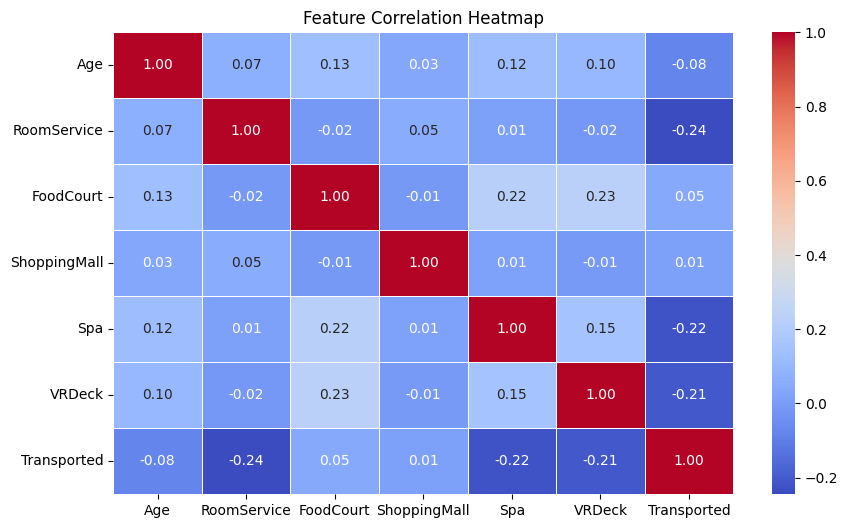

In [12]:
# 1. Correlation Heatmap for numerical features
plt.figure(figsize=(10,6))
num_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Transported"]
sns.heatmap(dataset_df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

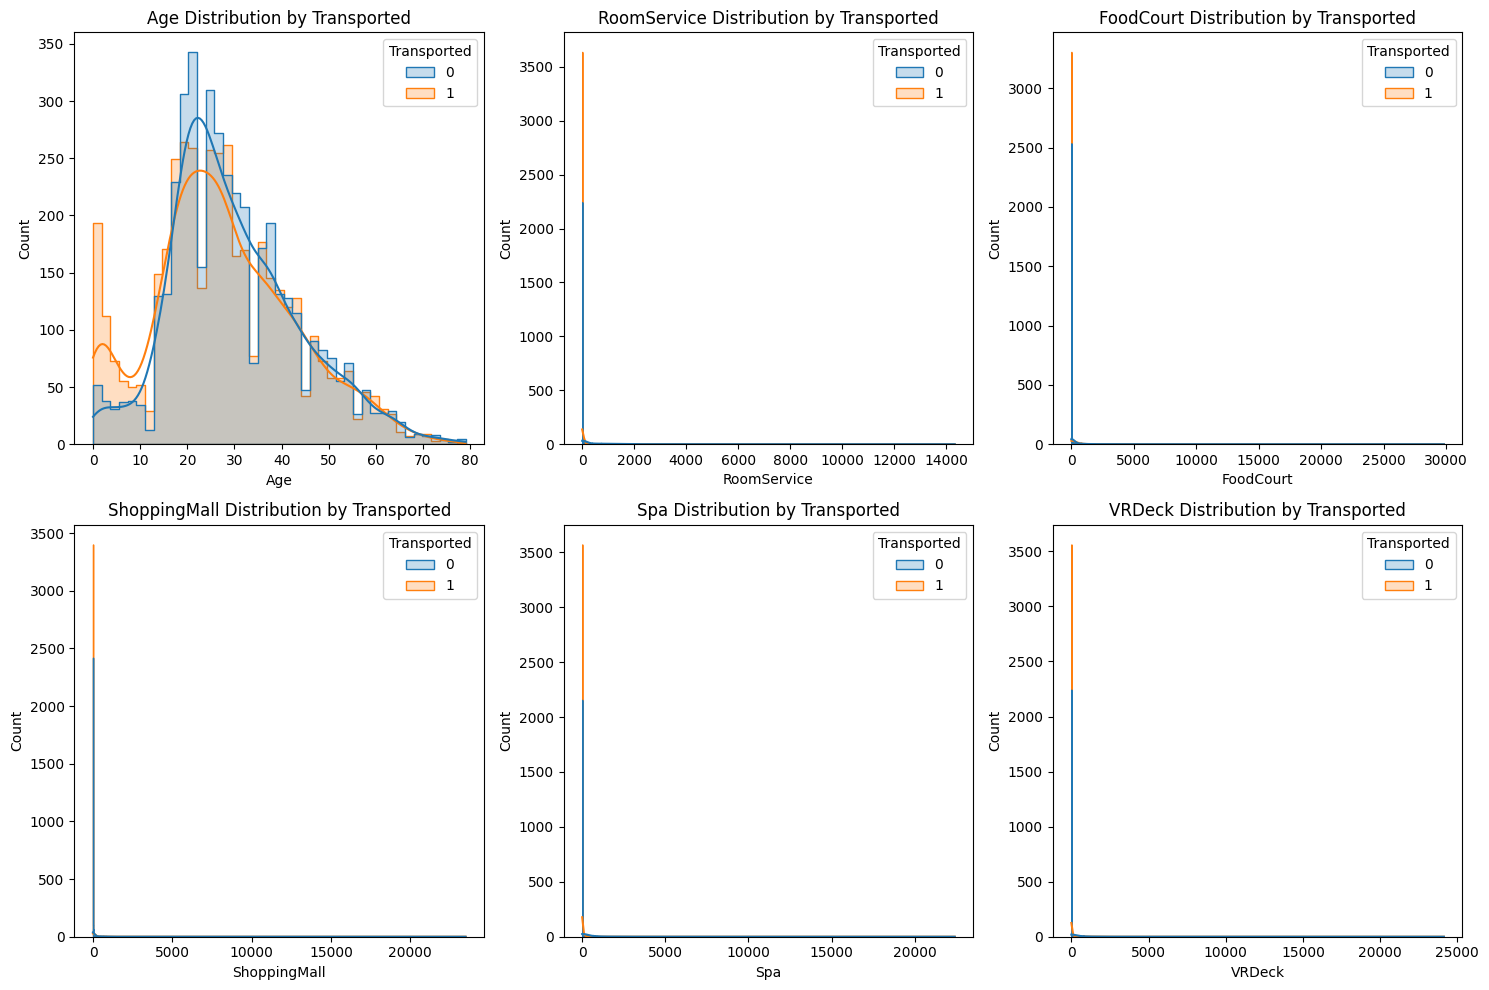

In [13]:
# 3. Feature Distributions by Target
fig, axes = plt.subplots(2, 3, figsize=(15,10))
num_features = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
for i, feature in enumerate(num_features):
    sns.histplot(data=dataset_df, x=feature, hue="Transported", element="step", kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"{feature} Distribution by Transported")
plt.tight_layout()
plt.show()

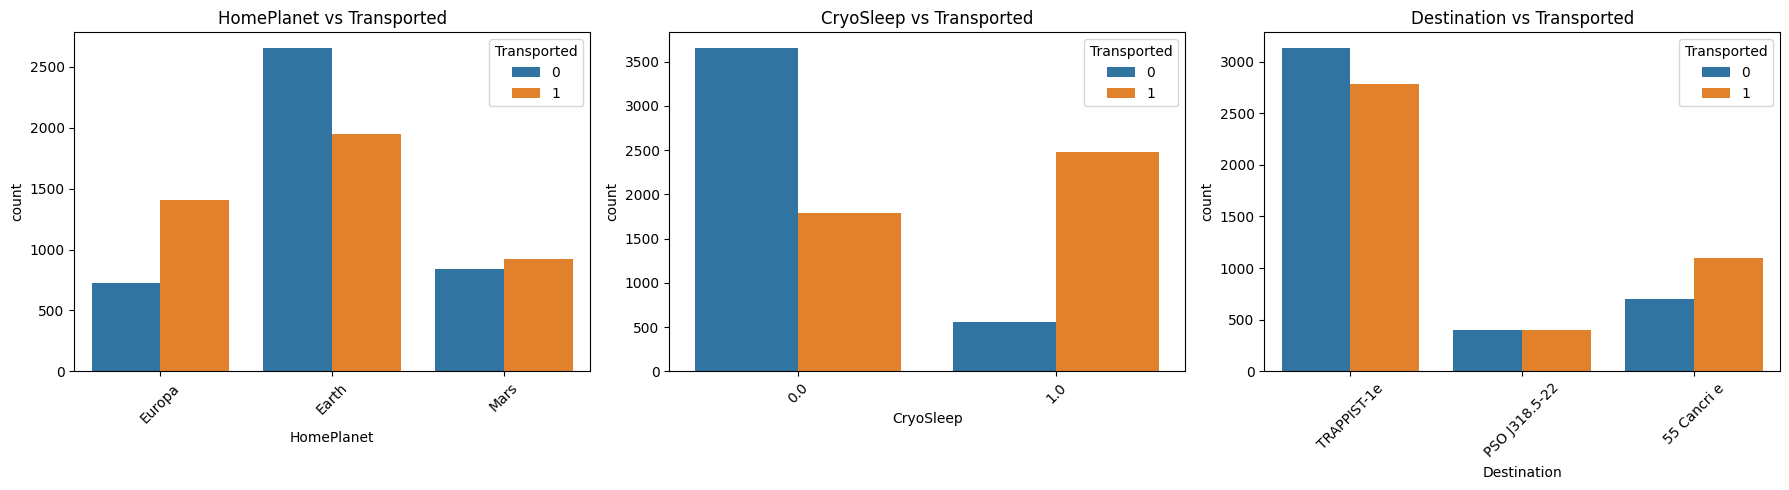

In [14]:
# 5. Categorical Feature Impact
fig, axes = plt.subplots(1, 3, figsize=(18,5))
categories = ["HomePlanet", "CryoSleep", "Destination"]
for i, cat in enumerate(categories):
    sns.countplot(data=dataset_df, x=cat, hue="Transported", ax=axes[i], palette=["#1f77b4", "#ff7f0e"])
    axes[i].set_title(f"{cat} vs Transported")
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Working on features


Replace NaN with median (for numerical) and most frequent (for categorical)

In [15]:
import pandas as pd

# Copy the dataset
cleaned_df = dataset_df.copy()

# List of numerical and categorical columns
numerical_columns = ['RoomService', 'Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_num']
categorical_columns = ['HomePlanet', 'CryoSleep', 'Deck', 'Side', 'Destination', 'VIP', 'Name']

# Check if 'Name' column exists in the DataFrame, and remove it from categorical_columns if it's missing
if 'Name' not in cleaned_df.columns:
    categorical_columns.remove('Name')

# Handle potential non-numeric issues in 'Cabin_num' by converting it to numeric
cleaned_df['Cabin_num'] = pd.to_numeric(cleaned_df['Cabin_num'], errors='coerce')

# Fill numerical columns with median (direct assignment)
for col in numerical_columns:
    cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].median())

# Fill categorical columns with the most frequent value (direct assignment)
for col in categorical_columns:
    cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].mode()[0])

In [16]:
bins = [0, 5, 10, 18, 25, 35, 45, 60, 100]
labels = ['0-5', '6-10', '11-18', '19-25', '26-35', '36-45', '46-60', '60+']

# Create a new feature 'Age_Group' based on the bins
cleaned_df['Age_Group'] = pd.cut(cleaned_df['Age'], bins=bins, labels=labels, right=False)


cleaned_df["TotalSpending"] = (
    cleaned_df["Spa"] + cleaned_df["VRDeck"] + 
    cleaned_df["RoomService"] + cleaned_df["ShoppingMall"] + 
    cleaned_df["FoodCourt"]
)

cleaned_df["LuxuryUser"] = (cleaned_df["Spa"] > 0) | (cleaned_df["VRDeck"] > 0) | (cleaned_df["RoomService"] > 0)
cleaned_df["SpendingPerAge"] = cleaned_df["TotalSpending"] / (cleaned_df["Age"] + 1)

cleaned_df["HighSpender"] = cleaned_df["TotalSpending"] > cleaned_df["TotalSpending"].median()

cleaned_df = cleaned_df.drop(columns = ["Age"])
cleaned_df = pd.get_dummies(cleaned_df, columns=['Age_Group'], drop_first=False)

print(cleaned_df.head())

  HomePlanet  CryoSleep  Destination  VIP  RoomService  FoodCourt  \
0     Europa        0.0  TRAPPIST-1e  0.0          0.0        0.0   
1      Earth        0.0  TRAPPIST-1e  0.0        109.0        9.0   
2     Europa        0.0  TRAPPIST-1e  1.0         43.0     3576.0   
3     Europa        0.0  TRAPPIST-1e  0.0          0.0     1283.0   
4      Earth        0.0  TRAPPIST-1e  0.0        303.0       70.0   

   ShoppingMall     Spa  VRDeck  Transported  ... SpendingPerAge  HighSpender  \
0           0.0     0.0     0.0            0  ...       0.000000        False   
1          25.0   549.0    44.0            1  ...      29.440000         True   
2           0.0  6715.0    49.0            0  ...     175.983051         True   
3         371.0  3329.0   193.0            0  ...     152.235294         True   
4         151.0   565.0     2.0            1  ...      64.176471         True   

  Age_Group_0-5  Age_Group_6-10  Age_Group_11-18  Age_Group_19-25  \
0         False           Fal

# Training


In [17]:
from sklearn.model_selection import train_test_split

# Split dataset (80% train, 20% test by default)


cleaned_df = cleaned_df.map(lambda x: int(x) if isinstance(x,bool) else x)
train_ds_pd, valid_ds_pd = train_test_split(cleaned_df, test_size=0.3, random_state=42)
print(cleaned_df.head())
# Print dataset sizes
#print(f"{len(train_ds_pd)} examples in training, {len(valid_ds_pd)} examples in testing.")

  HomePlanet  CryoSleep  Destination  VIP  RoomService  FoodCourt  \
0     Europa        0.0  TRAPPIST-1e  0.0          0.0        0.0   
1      Earth        0.0  TRAPPIST-1e  0.0        109.0        9.0   
2     Europa        0.0  TRAPPIST-1e  1.0         43.0     3576.0   
3     Europa        0.0  TRAPPIST-1e  0.0          0.0     1283.0   
4      Earth        0.0  TRAPPIST-1e  0.0        303.0       70.0   

   ShoppingMall     Spa  VRDeck  Transported  ... SpendingPerAge  HighSpender  \
0           0.0     0.0     0.0            0  ...       0.000000            0   
1          25.0   549.0    44.0            1  ...      29.440000            1   
2           0.0  6715.0    49.0            0  ...     175.983051            1   
3         371.0  3329.0   193.0            0  ...     152.235294            1   
4         151.0   565.0     2.0            1  ...      64.176471            1   

  Age_Group_0-5  Age_Group_6-10  Age_Group_11-18  Age_Group_19-25  \
0             0              

In [18]:
print(type(train_ds_pd))

<class 'pandas.core.frame.DataFrame'>


In [19]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

# Random Tree Forest


train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label="Transported")
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label="Transported")

rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")
rf.compile(metrics=["accuracy"])
rf.fit(x=train_ds)
inspector = rf.make_inspector()
print(inspector.evaluation())
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")


In [20]:
import tensorflow_decision_forests as tfdf



# Convert data to TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label="Transported")
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label="Transported")


# Initialize Gradient Boosted Trees model with tuned hyperparameters
gbm = tfdf.keras.GradientBoostedTreesModel(
    num_trees=300,                # More trees for better learning
    max_depth=8,                  # Deeper trees capture more complexity
    shrinkage=0.05,               # Lower learning rate for better convergence
    subsample=0.8,                # Random subsampling to reduce overfitting
)

gbm.compile(metrics=["accuracy"])

# Train the model
gbm.fit(x=train_ds)

# Inspect the trained model
inspector = gbm.make_inspector()
print(inspector.evaluation())

# Evaluate the model on validation data
evaluation = gbm.evaluate(x=valid_ds, return_dict=True)
for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

Use /tmp/tmpqf_yeuro as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.319458. Found 6085 examples.
Training model...
Model trained in 0:00:03.917806
Compiling model...
Model compiled.
Evaluation(num_examples=None, accuracy=0.7927031517028809, loss=0.7942966222763062, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.8033
loss: 0.0000
accuracy: 0.8033


from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label="Transported")
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label="Transported")
rf = RandomForestClassifier(n_estimators=200, max_depth=8)
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05)
lr = LogisticRegression()

ensemble_model = VotingClassifier(estimators=[
    ('rf', rf),
    ('xgb', xgb),
    ('lr', lr)
], voting='soft')

ensemble_model.fit(train_ds_pd.drop(columns=["Transported"]), train_ds_pd["Transported"])

In [21]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)
inspector.variable_importances()["NUM_AS_ROOT"]

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES
	 SUM_SCORE
	 NUM_AS_ROOT


[("LuxuryUser" (1; #15), 37.0),
 ("CryoSleep" (1; #9), 23.0),
 ("Spa" (1; #19), 16.0),
 ("VRDeck" (1; #23), 11.0),
 ("Deck" (4; #10), 7.0),
 ("Cabin_num" (1; #8), 6.0),
 ("Destination" (4; #11), 6.0),
 ("RoomService" (1; #16), 6.0),
 ("ShoppingMall" (1; #17), 6.0),
 ("SpendingPerAge" (1; #20), 5.0),
 ("Side" (4; #18), 4.0),
 ("TotalSpending" (1; #21), 2.0),
 ("Age_Group_0-5" (1; #0), 1.0),
 ("Age_Group_26-35" (1; #3), 1.0),
 ("FoodCourt" (1; #12), 1.0)]

In [22]:
#tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

# Submission


In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow_decision_forests as tfdf

# Load the test dataset
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission_id = test_df["PassengerId"]

# Fill missing values
test_df[['VIP', 'CryoSleep']] = test_df[['VIP', 'CryoSleep']].fillna(value=0)

# Create new features from Cabin
test_df[["Deck", "Cabin_num", "Side"]] = test_df["Cabin"].str.split("/", expand=True)
test_df.drop(columns=['Cabin'], inplace=True)

# Convert boolean features to 0s and 1s
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

bins = [0, 5, 10, 18, 25, 35, 45, 60, 100]
labels = ['0-5', '6-10', '11-18', '19-25', '26-35', '36-45', '46-60', '60+']

# Create a new feature 'Age_Group' based on the bins
test_df['Age_Group'] = pd.cut(test_df['Age'], bins=bins, labels=labels, right=False)

drop_features = ["Age"]

test_df['Cabin_num'] = pd.to_numeric(test_df['Cabin_num'], errors='coerce')

test_df["TotalSpending"] = (
    test_df["Spa"] + test_df["VRDeck"] + 
    test_df["RoomService"] + test_df["ShoppingMall"] + 
    test_df["FoodCourt"]
)

test_df["LuxuryUser"] = (test_df["Spa"] > 0) | (test_df["VRDeck"] > 0) | (test_df["RoomService"] > 0)
test_df["SpendingPerAge"] = test_df["TotalSpending"] / (test_df["Age"] + 1)

test_df["HighSpender"] = test_df["TotalSpending"] > test_df["TotalSpending"].median()
test_df = pd.get_dummies(test_df, columns=['Age_Group'], drop_first=False)

test_df = test_df.drop(columns=drop_features)
# Convert DataFrame to TensorFlow dataset
test_df = test_df.map(lambda x: int(x) if isinstance(x,bool) else x)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)


# Get predictions for test data
predictions = gbm.predict(test_ds)
n_predictions = (predictions > 0.5).astype(bool)

# Create submission file
output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


5/5 [==============================] - 0s 9ms/step


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [24]:
output.to_csv('/kaggle/working/submission.csv', index=False)
output.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


# Extra visualisation

import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()